# Import packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
import scipy.optimize as opt
%matplotlib widget

# Inputs

In [5]:
trapped_files = [
        # "Data/Trapped Particle 01 - 2M pts.CSV",
        # "Data/Trapped Particle 02 - 2M pts.CSV",
        # "Data/Trapped Particle 03 - 2M pts.CSV",
        # "Data/Trapped Particle 04 - 2M pts.CSV",
        # "Data/Trapped Particle 05 - 2M pts.CSV",
        "Data/Trapped 01 - 20M pts 10mins.CSV",
    ]
r_pixels = [
        # 23,
        # 23,
        # 23,
        # 23,
        # 23,
        23,
    ] # pixels
data_ranges = [
        # np.s_[:],
        # np.s_[:],
        # np.s_[:],
        # np.s_[21960:1937500],
        # np.s_[827:1937500],
        np.s_[:],
    ]
noise_files = ["Data/Untrapped 01 - 20M pts 10mins.CSV"]
noise_ranges = [np.s_[:]]
use_welch = True # Use Welch's method for PSD calculation (True) or FFT (False)
nperseg = 2**15 # Used for scipy.signal.welch PSD calculation
T = 297 # Kelvin
eta = 0.00089 # Viscosity of water (dependent on temperature)
pix_to_dist = 374.14 # px per div (10 microns)
min_freq, max_freq = 0, 10000 # Min and max frequencies (exclusive) for plotting and calculations after FFT
sampling_rate = 31200 # Sampling rate (Hz)
seconds_per_chunk = 60 # Number of seconds to chunk data into

In [6]:
assert len(trapped_files) == len(r_pixels) == len(data_ranges)

# Load, chunk, and de-mean data

In [7]:
# Read data files
trapped_data_list = [pd.read_csv(data_file, skiprows=15) for data_file in trapped_files]
noise_data_list = [pd.read_csv(noise_file, skiprows=15) for noise_file in noise_files]

# Extract data ranges
trapped_data_list = [data[data_range] for data, data_range in zip(trapped_data_list, data_ranges)]
noise_data_list = [noise[noise_range] for noise, noise_range in zip(noise_data_list, noise_ranges)]

In [8]:
# Copy r_pixels for each chunk of data
r_pixels = [r_pixel for r_pixel, data in zip(r_pixels, trapped_data_list) for _ in range(len(data) // (sampling_rate * seconds_per_chunk))]

# Chunk data into 1 minute segments
trapped_data_list = [df.iloc[i:i+sampling_rate * seconds_per_chunk] for df in trapped_data_list for i in range(0, len(df) - len(df) % (sampling_rate * seconds_per_chunk), sampling_rate * seconds_per_chunk)]
noise_data_list = [df.iloc[i:i+sampling_rate * seconds_per_chunk] for df in noise_data_list for i in range(0, len(df) - len(df) % (sampling_rate * seconds_per_chunk), sampling_rate * seconds_per_chunk)]

In [9]:
# De-mean signals (we don't care that this also de-means the time)
trapped_data_list = [df - df.mean() for df in trapped_data_list]
noise_data_list = [df - df.mean() for df in noise_data_list]

# Plot data (just for visual inspection)

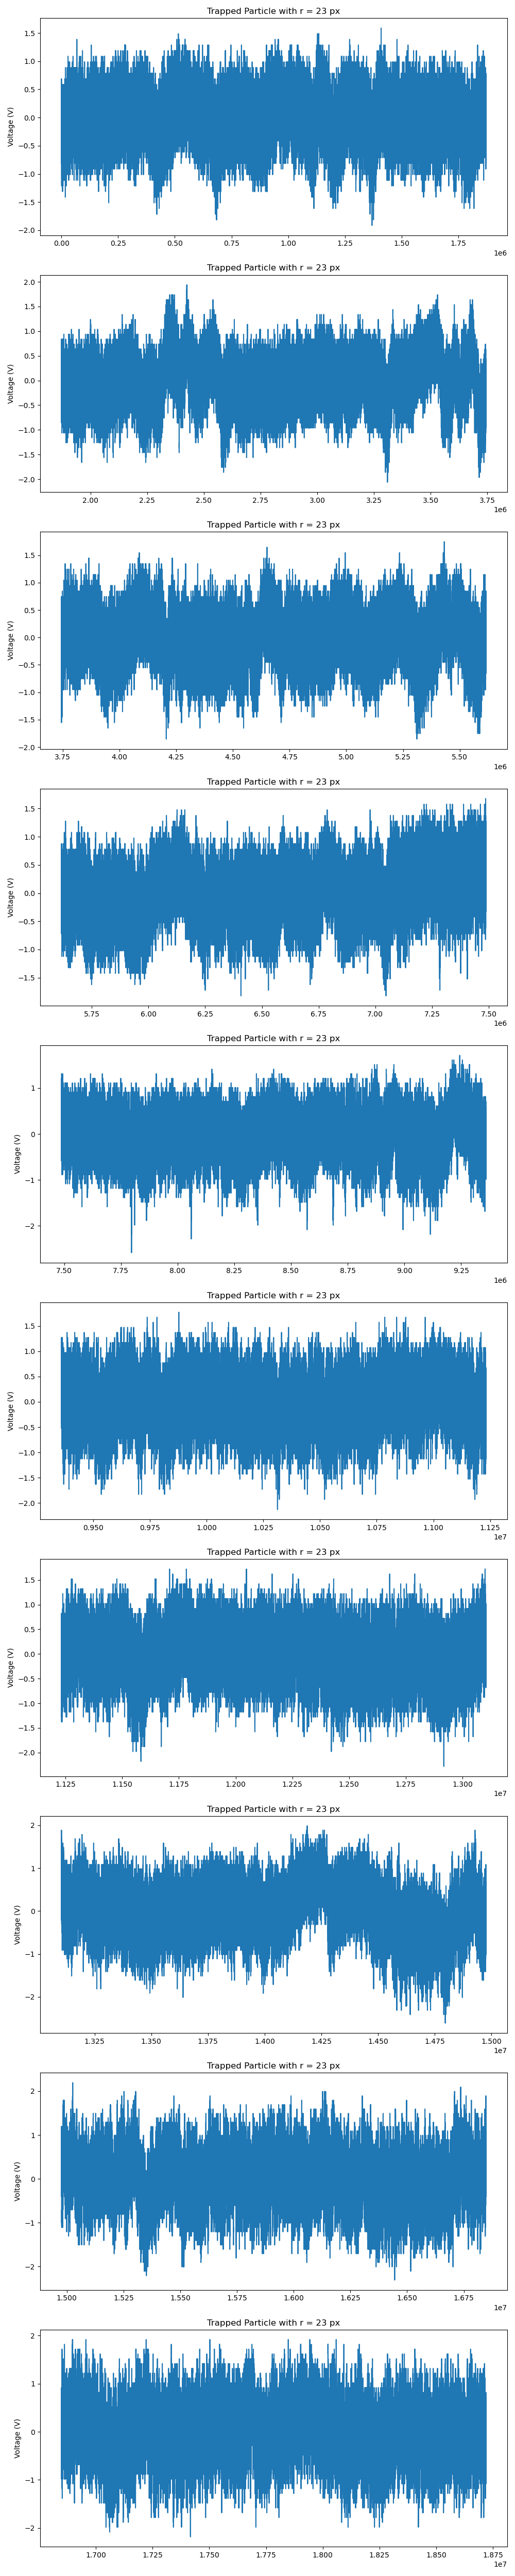

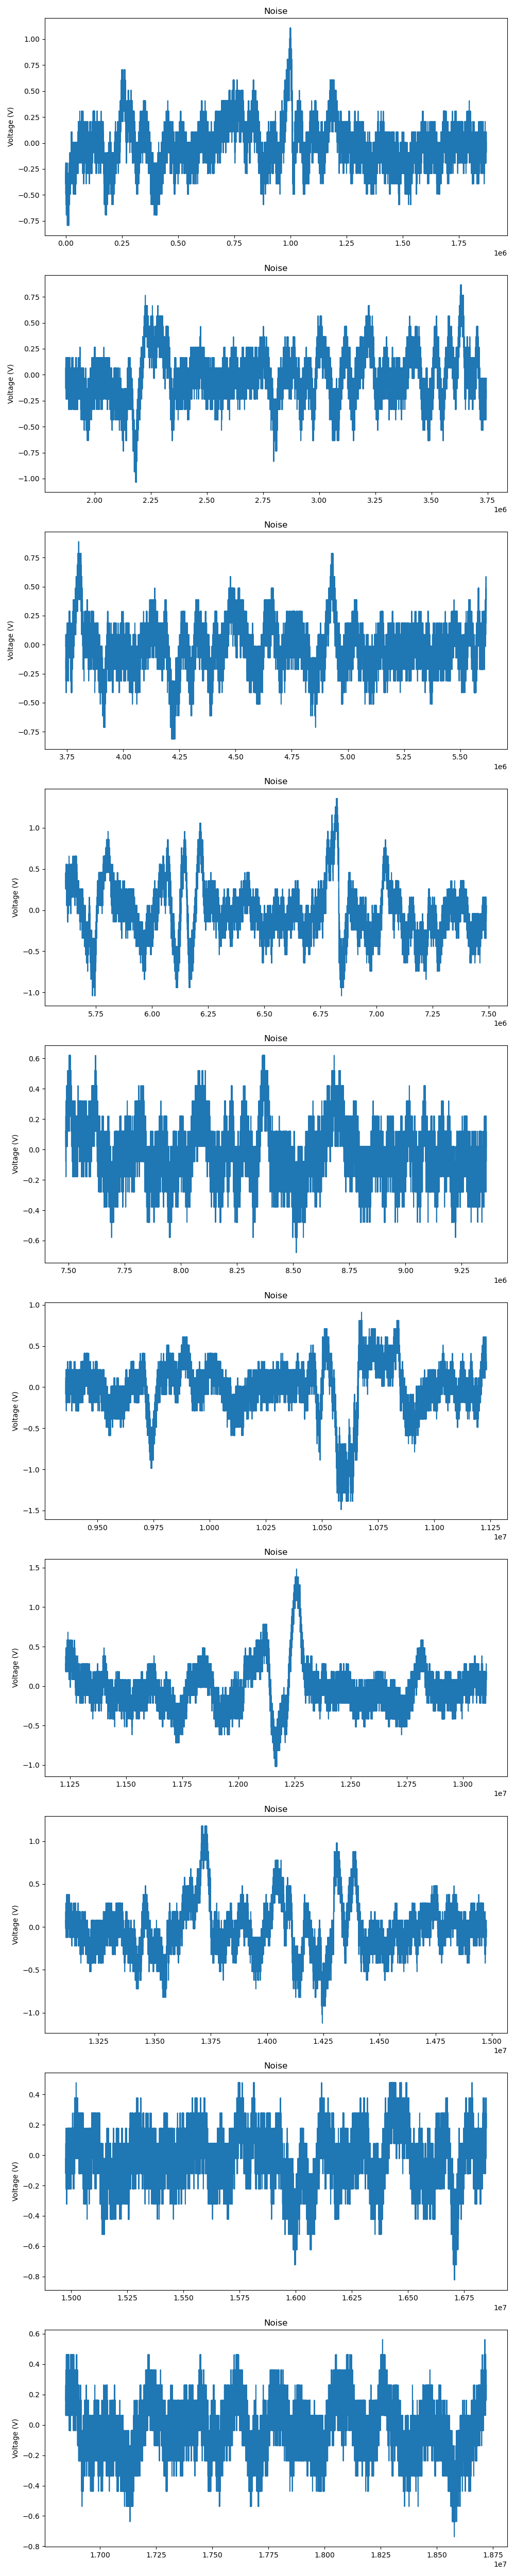

In [10]:
import matplotlib.pyplot as plt

# Plot trapped data
if trapped_data_list:
    fig, axs = plt.subplots(len(trapped_data_list), 1, figsize=(10, 5 * len(trapped_data_list)), squeeze=False)
    for ax, df, r in zip(axs[:, 0], trapped_data_list, r_pixels):
        ax.plot(df['CH1'])
        ax.set_title(f"Trapped Particle with r = {r} px")
        ax.set_ylabel("Voltage (V)")
    plt.tight_layout()
    plt.show()

# Plot noise data
if noise_data_list:
    fig, axs = plt.subplots(len(noise_data_list), 1, figsize=(10, 5 * len(noise_data_list)), squeeze=False)
    for ax, df in zip(axs[:, 0], noise_data_list):
        ax.plot(df['CH1'])
        ax.set_title("Noise")
        ax.set_ylabel("Voltage (V)")
    plt.tight_layout()
    plt.show()

# Calculating FFT and PSD

In [11]:
def get_psd(voltages, dt, total_timesteps, use_welch=use_welch, nperseg=nperseg):
    if use_welch:
        welch = signal.welch(voltages, fs=1/dt, nperseg=nperseg, scaling='density')
        freqs = welch[0]
        psd = welch[1]
    else:
        # Compute RFFT, PSD and frequency bins, sort the results by PSD
        fhat = np.fft.rfft(voltages, total_timesteps)
        psd = fhat * np.conj(fhat) / (total_timesteps * dt)
        # Adjust the PSD for the symmetry of the RFFT
        psd *= 2

        # Frequency bins for the RFFT
        freqs = np.fft.rfftfreq(total_timesteps, d=dt)

        # Verify that PSD is real
        assert np.allclose(psd, psd.real)
        psd = psd.real

    return pd.DataFrame({'Frequency': freqs, 'PSD': psd})

In [12]:
total_timesteps = sampling_rate * seconds_per_chunk # Get the total number of time steps

trapped_psd_list = [get_psd(df['CH1'], 1/sampling_rate, total_timesteps) for df in trapped_data_list]
noise_psd_list = [get_psd(df['CH1'], 1/sampling_rate, total_timesteps) for df in noise_data_list]

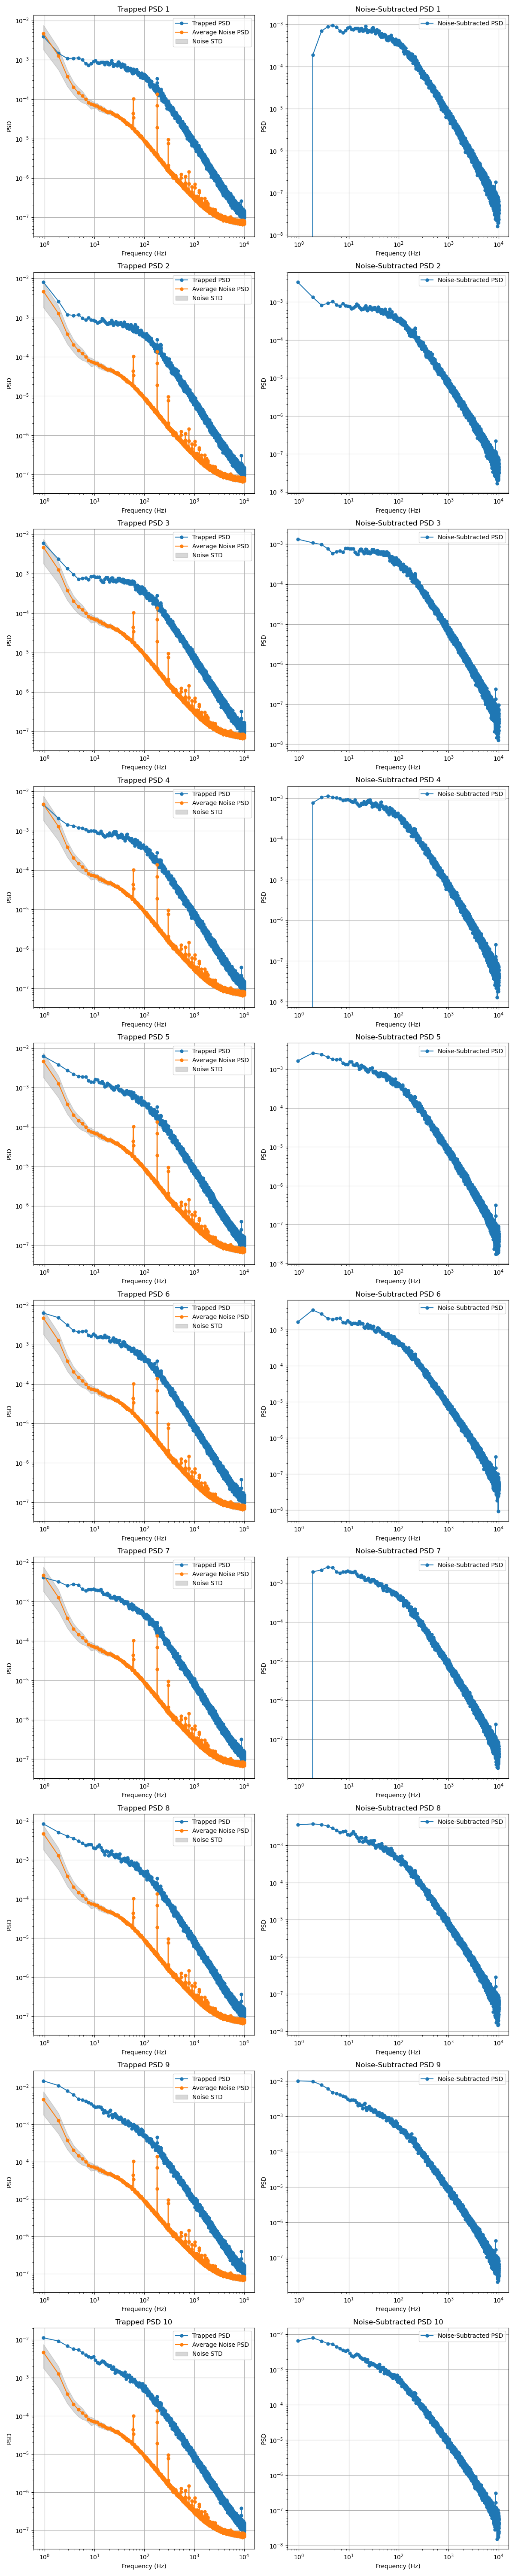

In [13]:
freqs = trapped_psd_list[0]['Frequency']

mask = freqs > min_freq # Ignore the zero frequency
mask &= freqs < max_freq # Ignore high frequency noise

avg_noise_psd = sum(noise_psd_list) / len(noise_psd_list)
avg_noise_psd['STD'] = np.std([df['PSD'] for df in noise_psd_list], axis=0)
difference_psd_list = [trapped_psd - avg_noise_psd for trapped_psd in trapped_psd_list]

# Create subplots
fig, axs = plt.subplots(len(trapped_psd_list), 2, figsize=(12, 6 * len(trapped_psd_list)), squeeze=False)

for i, (trapped_psd, difference_psd) in enumerate(zip(trapped_psd_list, difference_psd_list)):
    # Left: Trapped PSD with average noise
    ax = axs[i, 0]
    ax.plot(freqs[mask], trapped_psd['PSD'][mask], 'o-', markersize=5, label='Trapped PSD')
    ax.plot(freqs[mask], avg_noise_psd['PSD'][mask], 'o-', markersize=5, label='Average Noise PSD')
    ax.fill_between(
        freqs[mask],
        (avg_noise_psd['PSD'] - avg_noise_psd['STD'])[mask],
        (avg_noise_psd['PSD'] + avg_noise_psd['STD'])[mask],
        color='gray', alpha=0.3, label='Noise STD'
    )
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Trapped PSD {i+1}')
    ax.legend()
    ax.grid(True)

    # Right: Noise-subtracted PSD
    ax = axs[i, 1]
    ax.plot(freqs[mask], difference_psd['PSD'][mask], 'o-', markersize=5, label='Noise-Subtracted PSD')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Noise-Subtracted PSD {i+1}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# Lorentzian fitting to PSD

In [14]:
# Define the Lorentzian function with f0 and gamma as parameters
def lorentzian(f, gamma, f0, x2):
    return (2 * x2 * (gamma / (2 * np.pi))) / ((f - f0)**2 + (gamma / (2 * np.pi))**2)

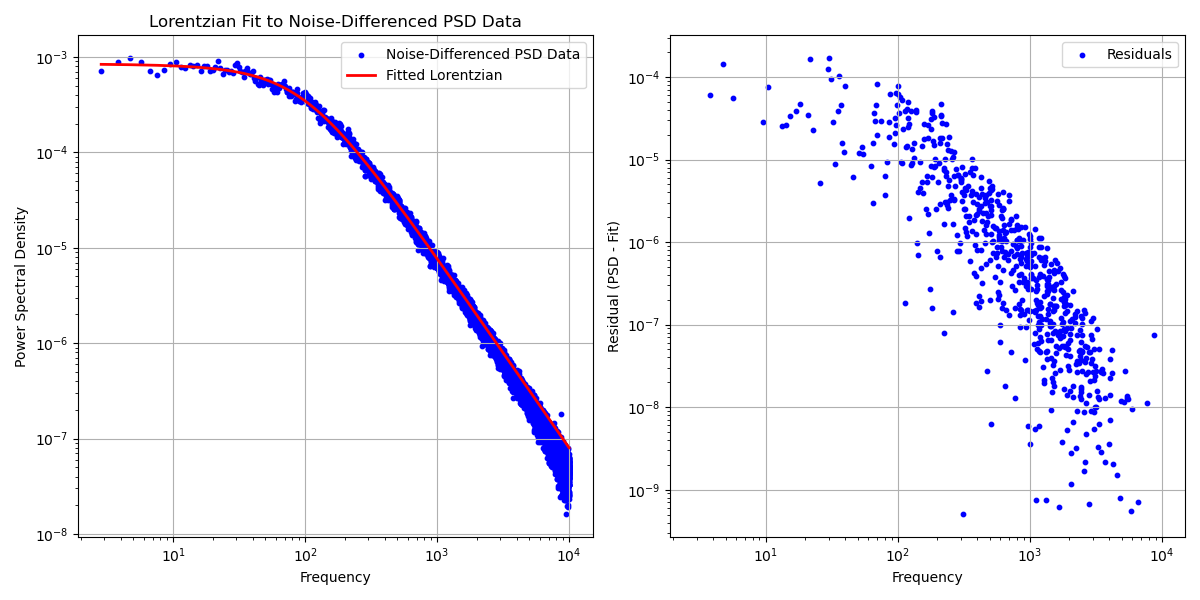

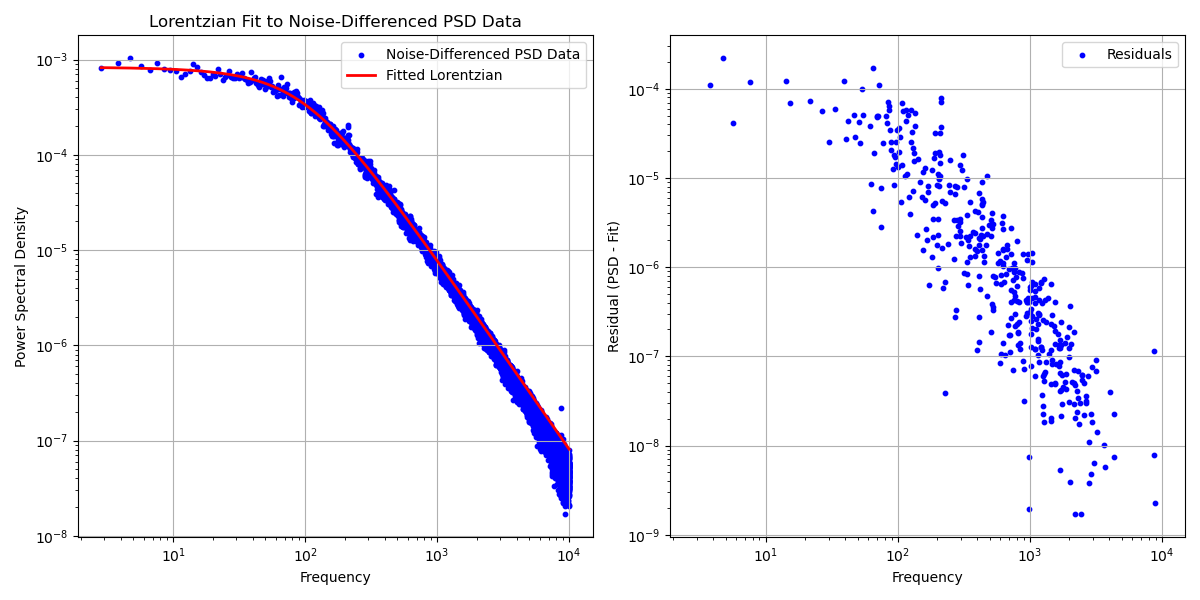

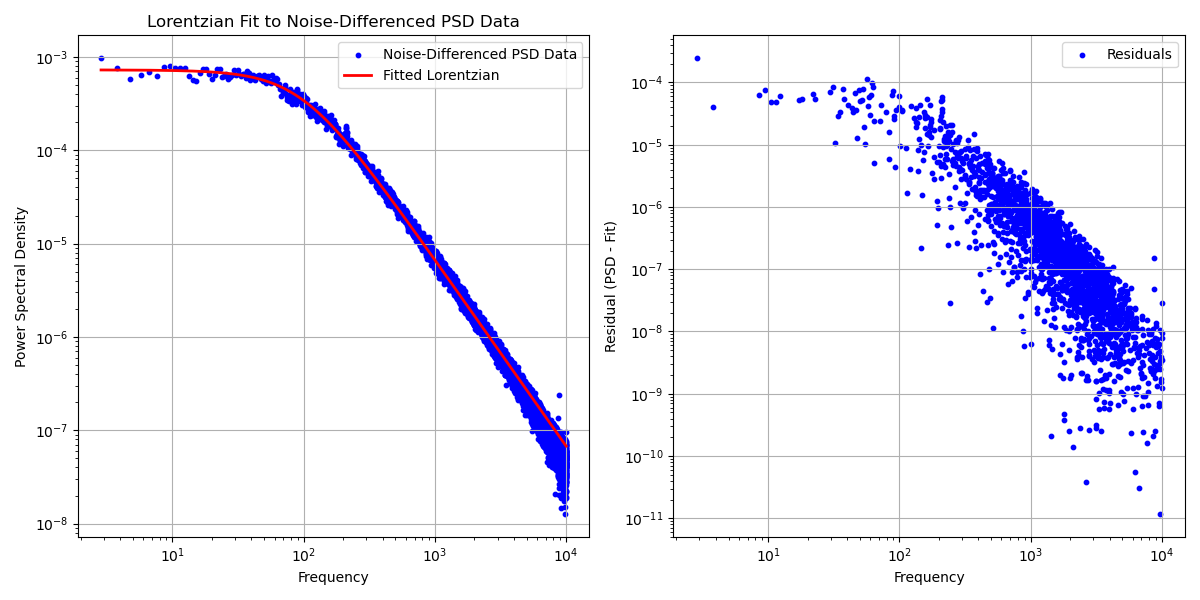

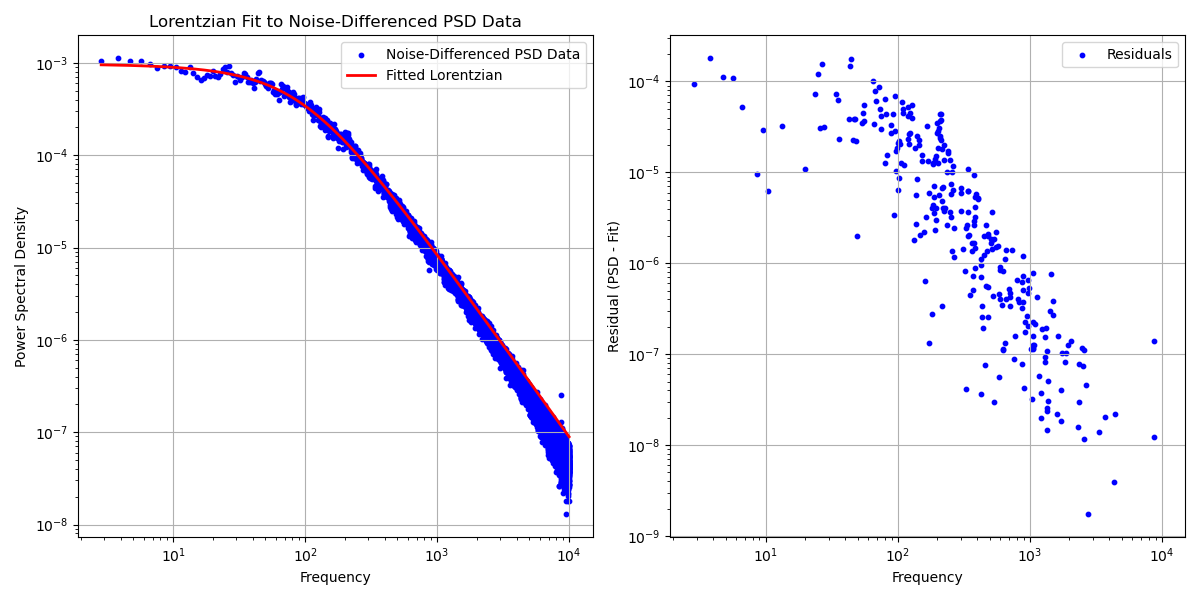

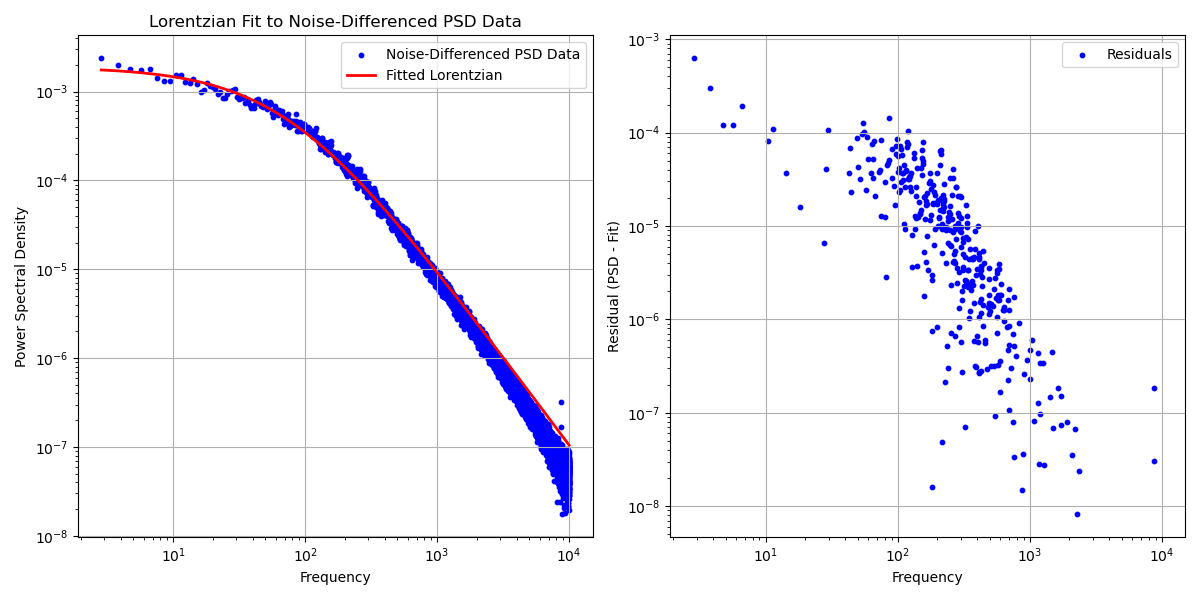

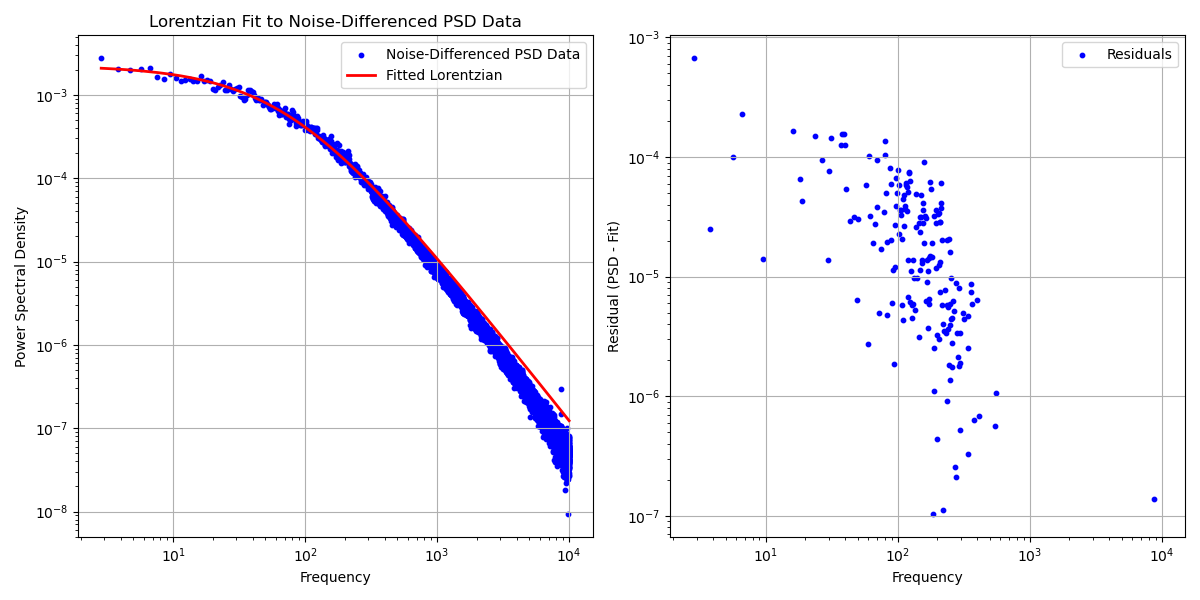

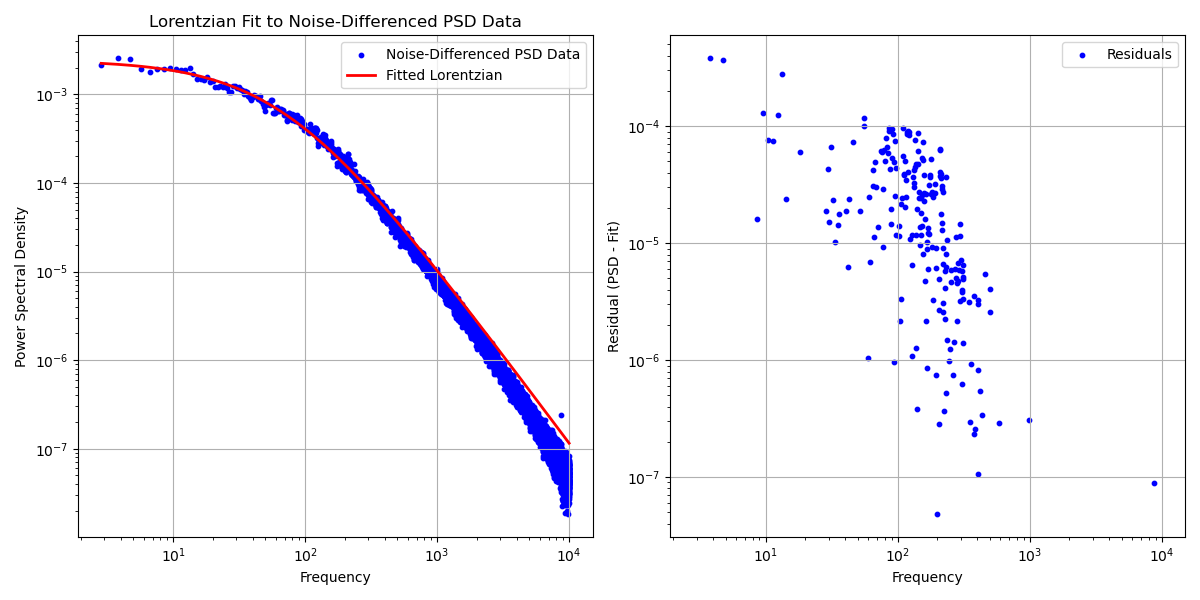

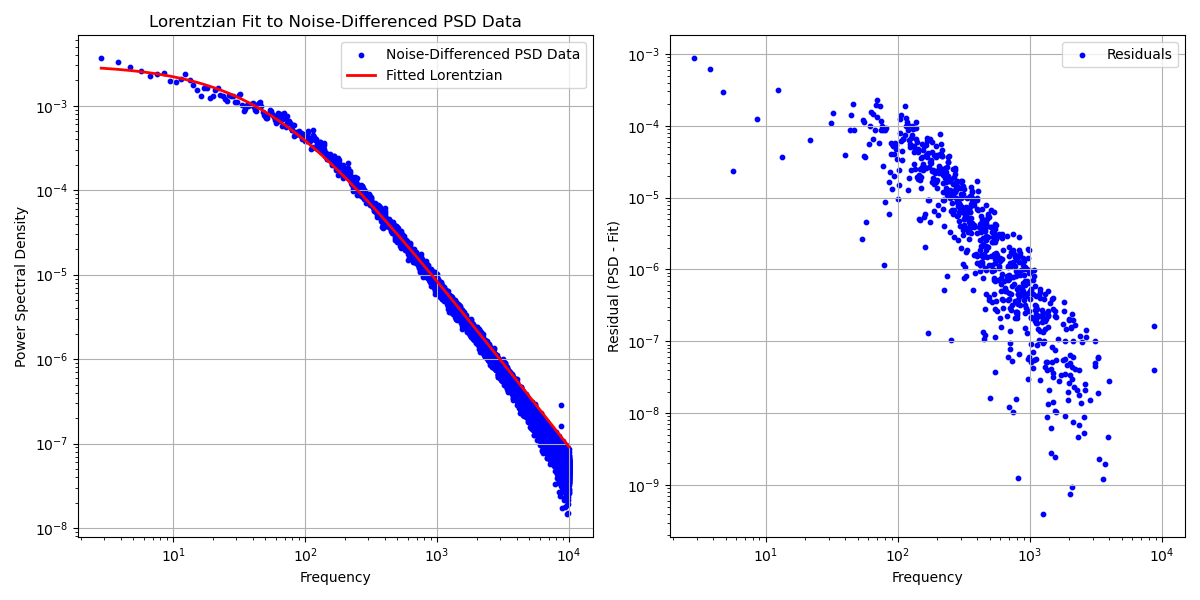

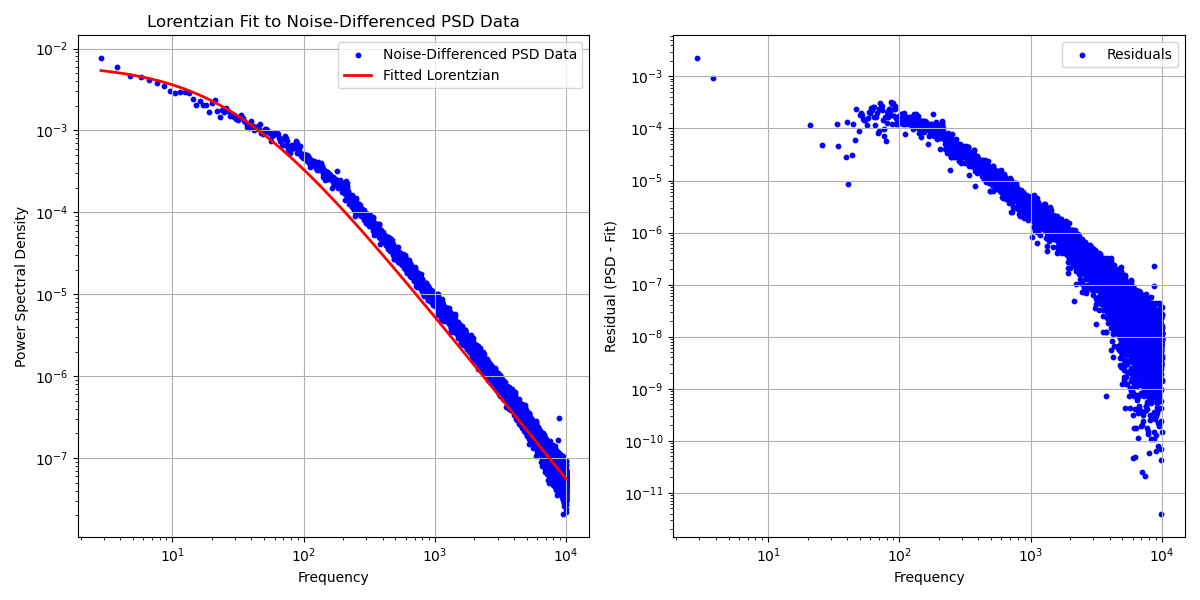

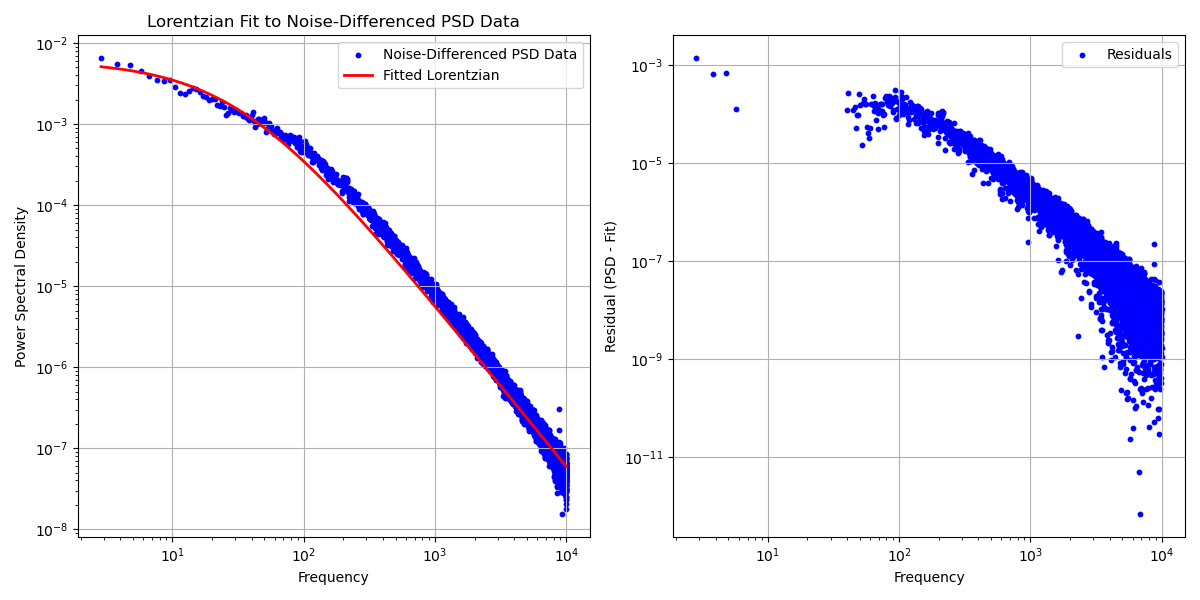

In [15]:
mask &= freqs > 2 # Cut off low frequencies to avoid anomalies with low frequency noise

# Compute expected x^2 for each trapped data frame
x_squared_expectation_list = [np.mean(df['CH1']**2) for df in trapped_data_list]

# Store fit parameters and covariance matrices
fit_params_list = []
cov_matrices_list = []

# Loop over each trapped PSD dataset and fit the Lorentzian model
for trapped_psd, difference_psd, x_squared_expectation in zip(trapped_psd_list, difference_psd_list, x_squared_expectation_list):
    
    # Initial guess for [Gamma, f0, x^2]
    initial_guess = [100.0, 0.0, x_squared_expectation]

    # Fit the Lorentzian function
    popt, pcov = opt.curve_fit(
        lambda f, gamma, f0, x2: lorentzian(f, gamma, f0, x2),
        freqs[mask],
        difference_psd['PSD'][mask],
        p0=initial_guess,
        maxfev=10000,
    )

    # Store results
    fit_params_list.append(popt)
    cov_matrices_list.append(pcov)

    # Extract optimal parameters
    gamma_opt, f0_opt, x2_opt = popt

    # Create side-by-side plots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Lorentzian fit
    axs[0].scatter(freqs[mask], difference_psd['PSD'][mask], label="Noise-Differenced PSD Data", color="blue", s=10)
    axs[0].plot(freqs[mask], lorentzian(freqs[mask], gamma_opt, f0_opt, x2_opt), label="Fitted Lorentzian", color="red", lw=2)
    axs[0].set_title("Lorentzian Fit to Noise-Differenced PSD Data")
    axs[0].set_xlabel("Frequency")
    axs[0].set_ylabel("Power Spectral Density")
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend()
    axs[0].grid(True)

    # Plot residuals
    residuals = difference_psd['PSD'][mask] - lorentzian(freqs[mask], gamma_opt, f0_opt, x2_opt)
    axs[1].scatter(freqs[mask], residuals, label="Residuals", color="blue", s=10)
    axs[1].set_xlabel("Frequency")
    axs[1].set_ylabel("Residual (PSD - Fit)")
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Rho calculation

In [16]:
kb = 1.380649e-23 # SI units
rs = np.array(r_pixels) / pix_to_dist * 1e-5 # Convert radius to meters

# S is psd, f is frequency
def rho(S, f, r):
    return np.sqrt(6 * np.pi**3 * eta * f**2 * S * r / kb / T)

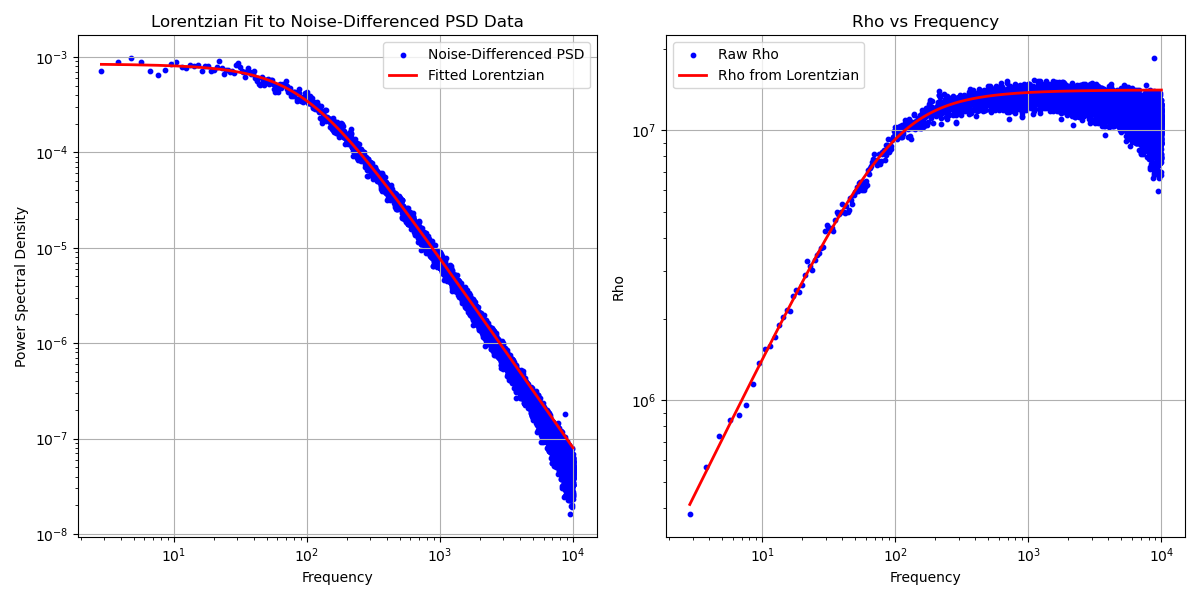

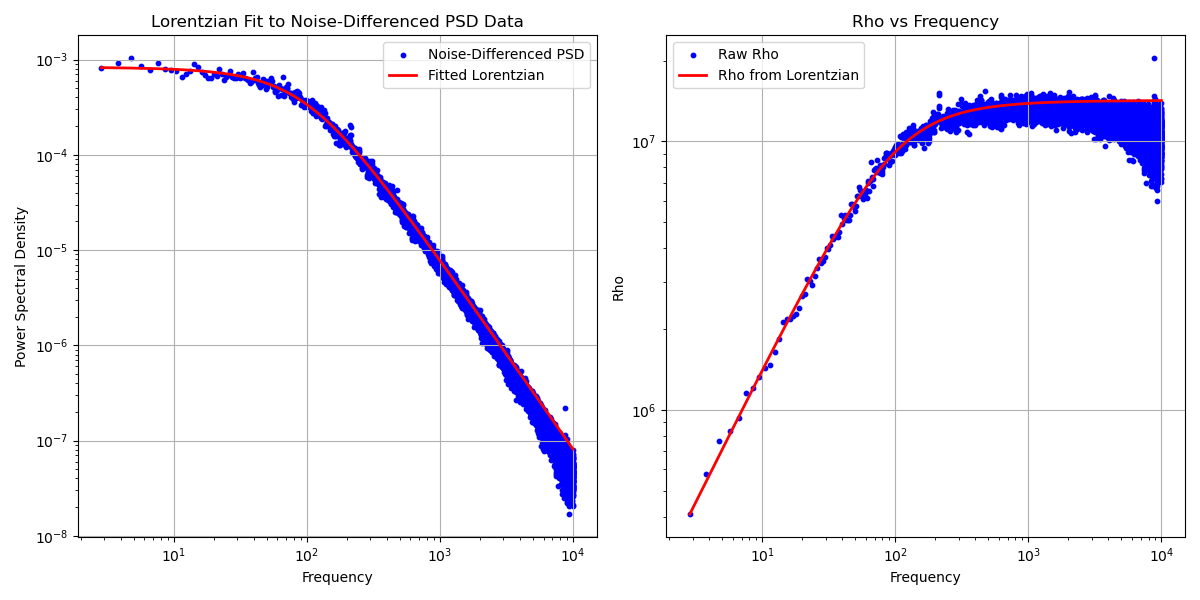

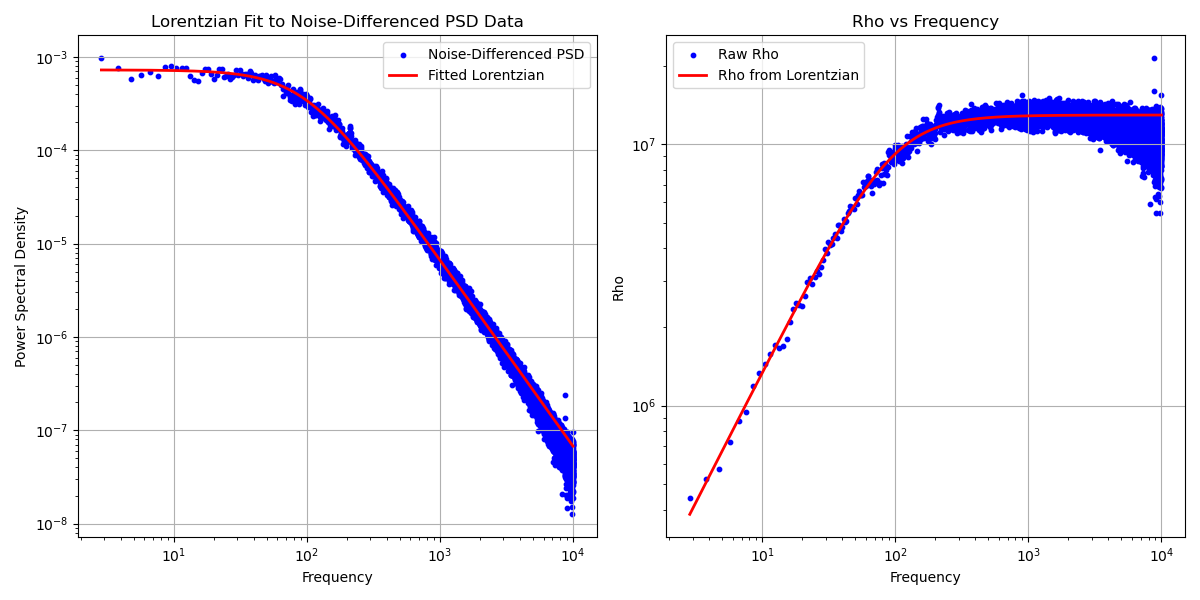

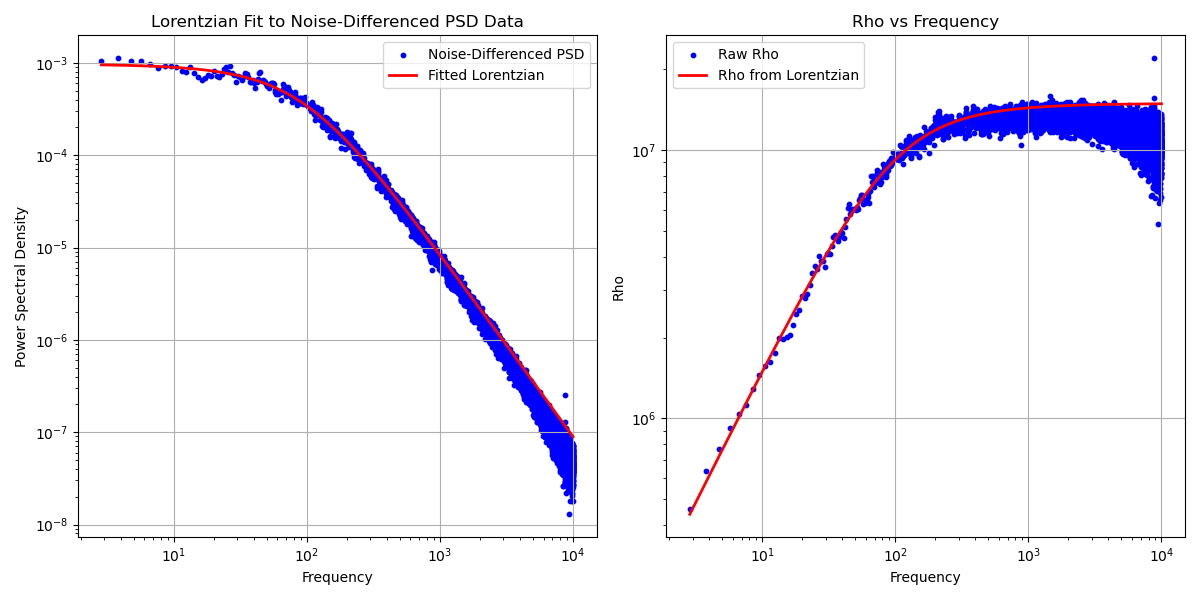

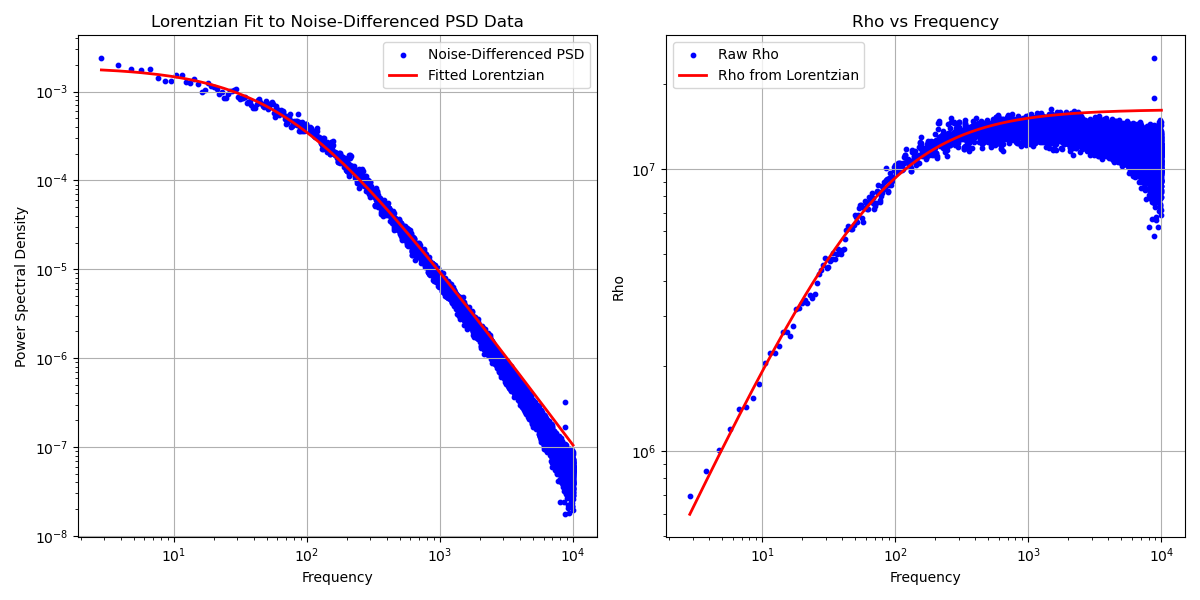

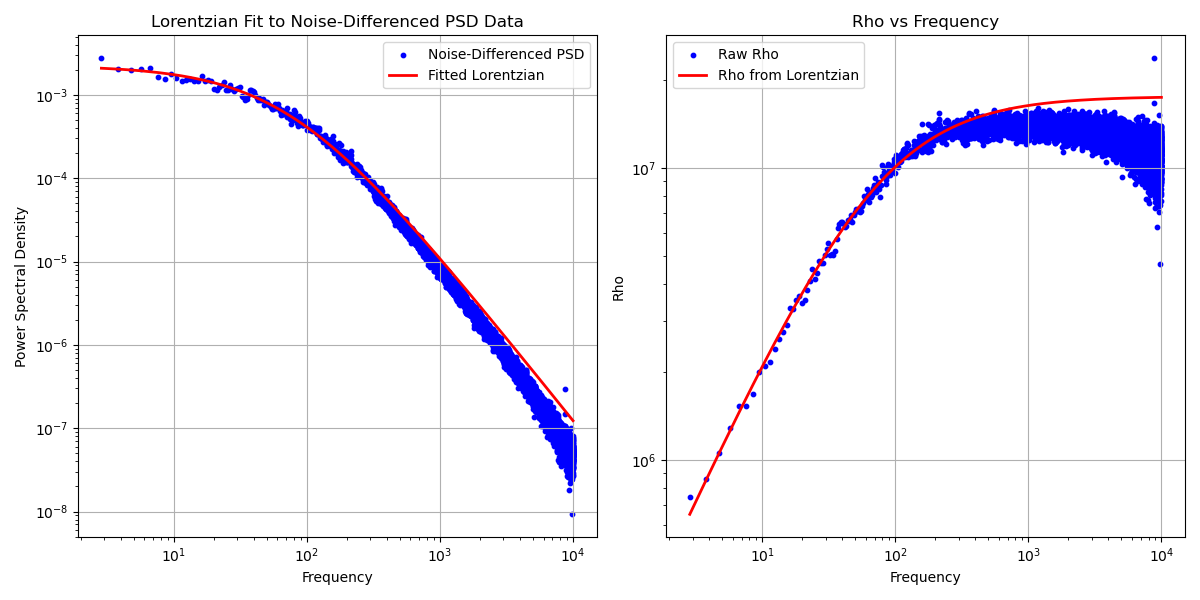

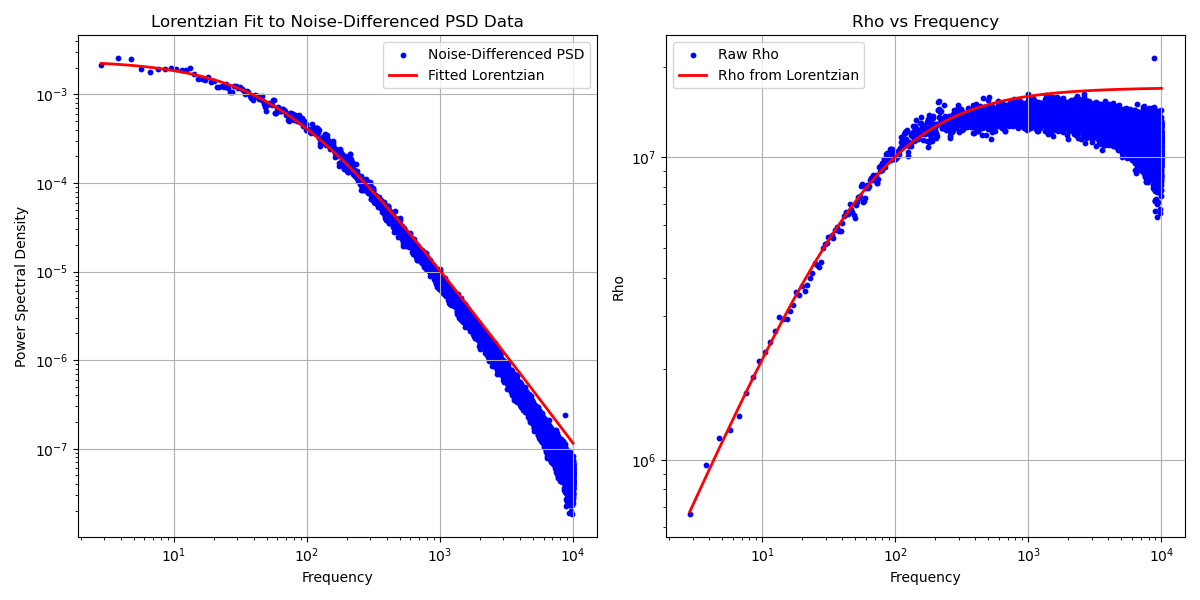

/var/folders/px/wy4h6r3d0pjcgpg5tm4lrp9h0000gn/T/ipykernel_85361/3213427873.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


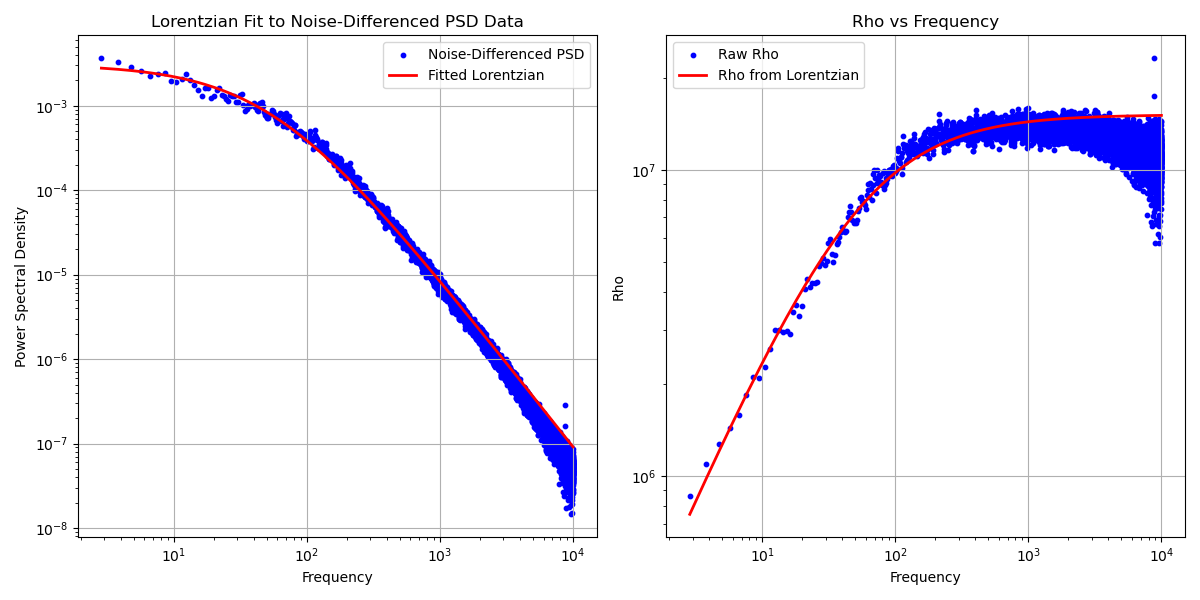

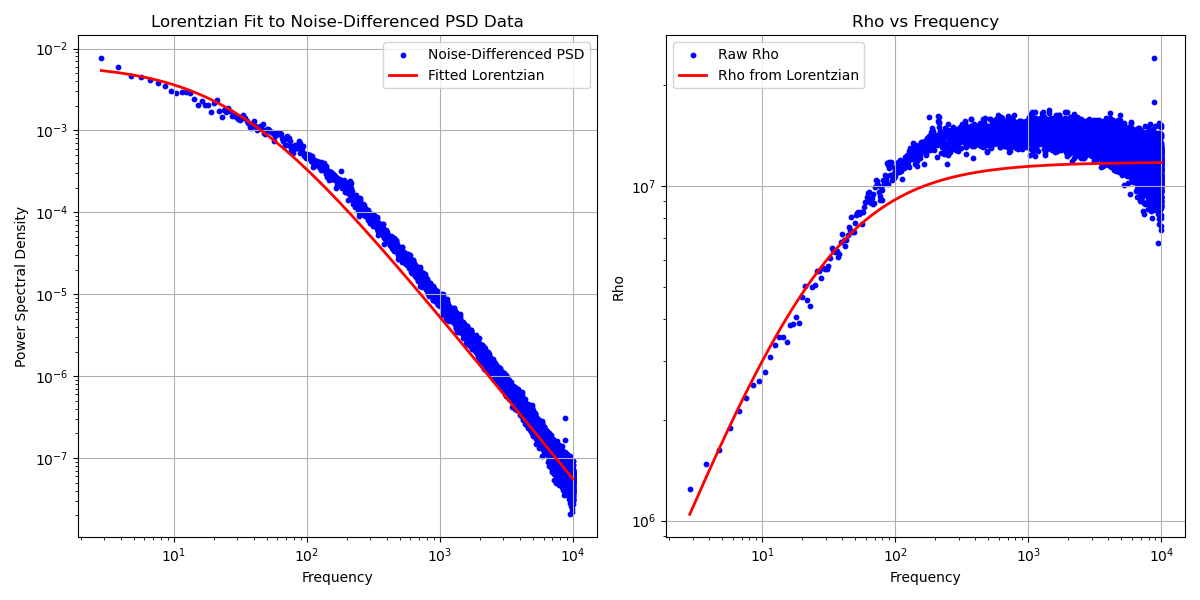

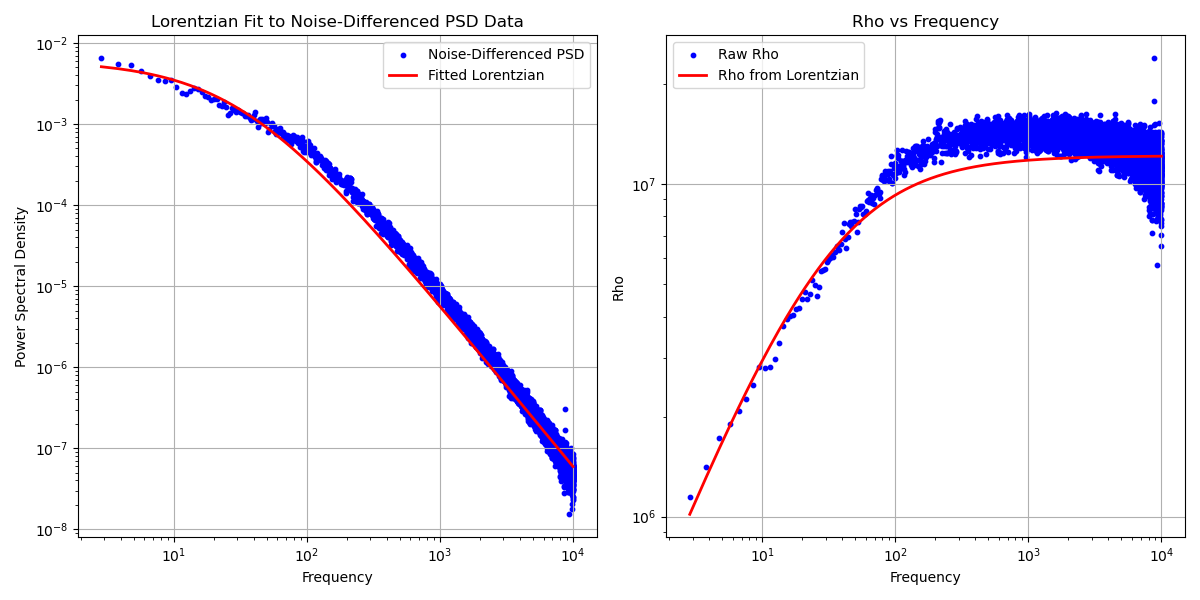

In [17]:
# Loop through all the trapped PSDs
for trapped_psd, difference_psd, popt, r in zip(trapped_psd_list, difference_psd_list, fit_params_list, rs):
    gamma_opt, f0_opt, x2_opt = popt  # Extract the optimal parameters

    # Create the figure for each dataset
    plt.figure(figsize=(12, 6))

    # Plot the Lorentzian fit to the PSD data
    plt.subplot(1, 2, 1)
    plt.scatter(freqs[mask], difference_psd['PSD'][mask], label="Noise-Differenced PSD", color="blue", s=10)
    plt.plot(freqs[mask], lorentzian(freqs[mask], gamma_opt, f0_opt, x2_opt), label="Fitted Lorentzian", color="red", lw=2)
    plt.title("Lorentzian Fit to Noise-Differenced PSD Data")
    plt.xlabel("Frequency")
    plt.ylabel("Power Spectral Density")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

    # Plot rho vs frequency
    plt.subplot(1, 2, 2)
    plt.scatter(freqs[mask], rho(difference_psd['PSD'][mask], freqs[mask], r), label="Raw Rho", color="blue", s=10)
    plt.plot(freqs[mask], rho(lorentzian(freqs[mask], gamma_opt, f0_opt, x2_opt), freqs[mask], r), label="Rho from Lorentzian", color="red", lw=2)
    plt.title("Rho vs Frequency")
    plt.xlabel("Frequency")
    plt.ylabel("Rho")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

    # Show the plot for the current dataset
    plt.tight_layout()
    plt.show()

# Averaging trapped PSDs

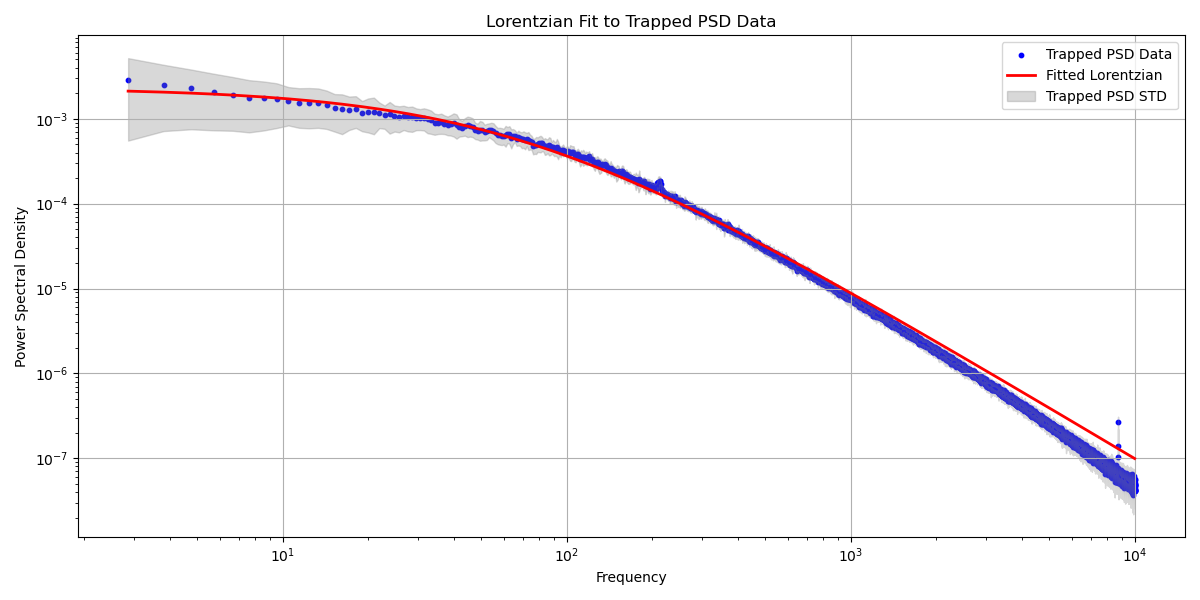

In [29]:
# Average the trapped PSDs and get std
avg_trapped_psd = sum(trapped_psd_list) / len(trapped_psd_list)
avg_trapped_psd['STD'] = np.std([df['PSD'] for df in trapped_psd_list], axis=0)

avg_difference_psd = avg_trapped_psd - avg_noise_psd
# Compute the standard deviation of the avg_difference_psd in quadrature
avg_difference_psd['STD'] = np.sqrt(avg_trapped_psd['STD']**2 + avg_noise_psd['STD']**2)

# Fit lorentzian to average trapped PSD
initial_guess = [100.0, 0.0, np.mean(x_squared_expectation_list)]
popt, pcov = opt.curve_fit(
    lambda f, gamma, f0, x2: lorentzian(f, gamma, f0, x2),
    freqs[mask],
    avg_difference_psd['PSD'][mask],
    p0=initial_guess,
    maxfev=10000,
    # sigma=avg_difference_psd['STD'][mask],
    # absolute_sigma=True,
)

# Extract optimal parameters
gamma_opt, f0_opt, x2_opt = popt

mask2 = mask & (freqs > 55)

# Also fit lorentzian to the residuals
residuals = avg_difference_psd['PSD'][mask2] - lorentzian(freqs[mask2], gamma_opt, f0_opt, x2_opt)
residuals_popt, residuals_pcov = opt.curve_fit(
    lambda f, gamma, f0, x2: lorentzian(f, gamma, f0, x2),
    freqs[mask2],
    residuals,
    p0=initial_guess,
    maxfev=10000,
)

# Extract optimal parameters
residuals_gamma_opt, residuals_f0_opt, residuals_x2_opt = residuals_popt

if False:
    # Create side-by-side plots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Lorentzian fit
    axs[0].scatter(freqs[mask], avg_difference_psd['PSD'][mask], label="Trapped PSD Data", color="blue", s=10)
    axs[0].plot(freqs[mask], lorentzian(freqs[mask], gamma_opt, f0_opt, x2_opt), label="Fitted Lorentzian", color="red", lw=2)
    axs[0].fill_between(
        freqs[mask],
        (avg_difference_psd['PSD'] - avg_difference_psd['STD'])[mask],
        (avg_difference_psd['PSD'] + avg_difference_psd['STD'])[mask],
        color='gray', alpha=0.3, label='Trapped PSD STD'
    )
    axs[0].set_title("Lorentzian Fit to Trapped PSD Data")
    axs[0].set_xlabel("Frequency")
    axs[0].set_ylabel("Power Spectral Density")
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend()
    axs[0].grid(True)

    # Plot residuals
    axs[1].scatter(freqs[mask2], residuals, label="Residuals", color="blue", s=10)
    axs[1].plot(freqs[mask2], lorentzian(freqs[mask2], residuals_gamma_opt, residuals_f0_opt, residuals_x2_opt), label="Fitted Lorentzian", color="red", lw=2)
    axs[1].set_title("Lorentzian Fit to Residuals")
    axs[1].set_xlabel("Frequency")
    axs[1].set_ylabel("Residual (PSD - Fit)")
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()
else:
    # Just plot the Lorentzian fit for the avergae difference PSD
    plt.figure(figsize=(12, 6))
    plt.scatter(freqs[mask], avg_difference_psd['PSD'][mask], label="Trapped PSD Data", color="blue", s=10)
    plt.plot(freqs[mask], lorentzian(freqs[mask], gamma_opt, f0_opt, x2_opt), label="Fitted Lorentzian", color="red", lw=2)

    plt.fill_between(
        freqs[mask],
        (avg_difference_psd['PSD'] - avg_difference_psd['STD'])[mask],
        (avg_difference_psd['PSD'] + avg_difference_psd['STD'])[mask],
        color='gray', alpha=0.3, label='Trapped PSD STD'
    )

    plt.title("Lorentzian Fit to Trapped PSD Data")
    plt.xlabel("Frequency")
    plt.ylabel("Power Spectral Density")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Pick rho

In [19]:
rho = 20.1e7 # Select a rho value

# Calculate diffusion constant

In [20]:
rho = 2.1e7 # Select a rho value

data['x'] = data['CH1'] / rho
data['x'] = data['x'] - data['x'].mean() # Center the data
x_squared_expectation = (data['x']**2).mean() # Meters squared
print(x_squared_expectation)

k = kb * T / x_squared_expectation # Spring constant
zeta = 6 * np.pi * eta * r # Mobility
gamma = k / zeta # Characteristic relaxation rate
D = gamma * x_squared_expectation # Diffusion coefficient
print("Diffusion coefficient: ", np.round(D, 17))

NameError: name 'data' is not defined

In [103]:
# NOTE: This is the simplified version of the D formula in the cell above
# It doesn't really rely on the data we take (other than basic stuff like T and r)
# TODO: we should make sure we're actually using a formula for which rho doesn't cancel out
D = kb * T / (6 * np.pi * eta * r)